In [1]:
!pip install meteocalc

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
#!unzip -q ashrae.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot
%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")
from sklearn.utils import shuffle

from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Model 
from keras.layers import Input, Dense, Lambda
from keras.layers import Embedding, Flatten, Dropout, Add, Activation
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,EarlyStopping
import keras.backend as K

# importer les fichiers .py sur le notebook
%run utils.py
%run feature_enginering.py

In [4]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

train.loc[(train.meter == 0),'meter_reading'] = train['meter_reading'] * 0.2931 # convertir du kwh vers kbtu

In [5]:
building = reduce_mem_usage(building)
weather  = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

In [6]:
building = prepare_building_data(building)
weather = prepare_weather_data(weather)
train  = time_features(train)

In [7]:
def join_data(data , weather_data , building_data):

    data = data.merge(building_data, on = 'building_id' , how='left')
    data = data.merge(weather_data , on = ['site_id','timestamp'], how= 'left')
    data = shuffle(data, random_state=0)

    return data

In [8]:
train = join_data(train , weather , building)

train['log_meter_reading'] = np.log(train['meter_reading'] + 1)
train['month_group'] = train['month_group'] - 1

train = train.drop(['meter_reading'] , axis= 1)

train  = reduce_mem_usage(train)
del weather, building
gc.collect()

26

In [9]:
print(len(train.columns))
print(train.columns)
print(train.shape)

24
Index(['building_id', 'meter', 'timestamp', 'hour', 'dayofweek', 'month_group',
       'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'relative_humidity', 'feels_like', 'city', 'country',
       'is_holiday', 'log_meter_reading'],
      dtype='object')
(20216100, 24)


In [10]:
for col in train.columns:
  if train[col].isnull().values.any():
    print(col , 'il y a', train[col].isnull().values.sum() , ' Nan ')

air_temperature il y a 90495  Nan 
cloud_coverage il y a 90495  Nan 
dew_temperature il y a 90495  Nan 
precip_depth_1_hr il y a 90495  Nan 
sea_level_pressure il y a 90495  Nan 
wind_direction il y a 90495  Nan 
wind_speed il y a 90495  Nan 
relative_humidity il y a 90495  Nan 
feels_like il y a 90495  Nan 
city il y a 90495  Nan 
country il y a 90495  Nan 
is_holiday il y a 90495  Nan 


In [11]:
cols_to_drop = ['year_built' , 'floor_count' , 'timestamp']

cols_to_scale = ['square_feet' , 'air_temperature' , 'dew_temperature' ,
                 'wind_speed', 'cloud_coverage', 'sea_level_pressure', 'wind_direction',
                 'relative_humidity', 'feels_like']

cols_to_encode = ['primary_use' , 'city' , 'country']

cols_to_fill_median = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                       'sea_level_pressure','wind_direction' , 'wind_speed', 'relative_humidity' ,
                       'feels_like']

cols_to_fill_categ = ['city' , 'country' , 'is_holiday']


Filler = Data_Filler(cols_to_fill_median,
                     cols_to_fill_categ)

Filler.fit(train)
train = Filler.transform(train)

ScalerEncoder = Data_Scaler_Encoder(cols_to_scale ,
                                    cols_to_drop , 
                                    cols_to_encode)
ScalerEncoder.fit(train)
train = ScalerEncoder.transform(train)

In [12]:
def residual_block(input_x, nodes):
    d1 = Dense(nodes,activation='relu')(input_x)
    d2 = Dense(nodes,activation='relu')(d1)

    projected_x = Dense(nodes,activation='relu')(input_x)

    add = Add()([projected_x , d2])
    return add

def create_model(data , categorical_vars , numerical_vars):
    categ_inputs = []
    embed_layers = []  
    for col in categorical_vars:
        num_classes = len(np.unique(data[col]))

        input_x = Input(shape = [1] , name = col)
        categ_inputs.append(input_x)

        embed_x = Embedding(num_classes, 2)(input_x)
        embed_layers.append(embed_x)

    num_inputs = []
    for col in numerical_vars:
        num_inputs.append(Input(shape=[1] , name = col))

    concat_emb = K.concatenate([Flatten()(emb_layer) for emb_layer in embed_layers])

    d1 = residual_block(concat_emb , 1024) # 512
    #d1 = residual_block(d1 , 256)
    main = K.concatenate(num_inputs + [d1])

    d2 = residual_block(main , 1024) # 512
    d2 = residual_block(d2 , 256)
    #d2 = residual_block(d2 , 256)
    d2 = residual_block(d2 , 8)

    df = Dense(3 , name='second_to_last_layer')(d2)

    output = Dense(1)(df)
    model  = Model(categ_inputs + num_inputs, output)

    return model 

def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [13]:
train.head()

,building_id,meter,hour,dayofweek,month_group,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,city,country,is_holiday,log_meter_reading
11990877,774,1,8,6,2,6,4,-0.121928,0.622309,-0.493968,1.335863,0.000000,0.971994,-1.508241,-1.586555,1.220804,0.625725,12,3,0.0,3.614396
15256244,206,0,14,1,2,2,9,2.032176,-0.004326,-0.902715,-0.443634,0.000000,0.950487,-0.693963,-0.905198,-0.907559,0.046760,11,3,0.0,4.209454
18401495,1269,0,10,1,2,14,3,-0.438739,-0.733841,-0.902715,-0.273682,0.000000,1.015009,-0.603487,-0.405537,0.755967,-0.627258,7,3,0.0,2.241073
15573710,951,0,4,0,2,9,6,-0.032943,0.098554,-0.902715,-0.213699,0.000000,1.066786,-1.508241,-1.586555,-0.727844,0.141815,0,3,1.0,3.529892
6515439,656,0,21,6,1,5,7,-0.870854,-0.481317,-0.902715,0.226177,-0.041667,0.990017,1.206021,-0.405537,1.372431,-0.393944,10,2,0.0,2.359378


In [14]:
categorical_vars = ['building_id' , 'meter', 'hour', 'dayofweek' , 'month_group', 'site_id' , 
                    'primary_use', 'city', 'country', 'is_holiday']
                    
numerical_vars = ['square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
                  'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 
                  'relative_humidity' , 'feels_like']

target_var = 'log_meter_reading'

model = create_model(train, categorical_vars, numerical_vars)

In [15]:
y = train[target_var].values
y = y.reshape((len(y) , 1))

train = train.drop( [target_var] , axis = 1)

co_vars = categorical_vars + numerical_vars
train = train[co_vars].values

train = [ train[:,i].flatten() for i in range(len(train[0,:])) ]

In [16]:
checkpoint = ModelCheckpoint( '/content/drive/MyDrive/model_ann_test.h5', 
                                monitor = 'val_rmse', 
                                verbose = 1, 
                                save_best_only = True, 
                                mode = 'min')

early_stopping = EarlyStopping(patience = 5 ,monitor = "val_rmse")
callbacks_list = [checkpoint , early_stopping]

model.compile(optimizer = Adam(lr = 1e-3), loss = 'mse',  metrics = [rmse])
history = model.fit(train, y, 
                    epochs = 150,
                    batch_size = 1024, 
                    callbacks = callbacks_list, 
                    validation_split = 0.20)

Epoch 1/150
15794/15794 [==============================] - 231s 14ms/step - loss: 1.0163 - rmse: 0.9626 - val_loss: 0.5517 - val_rmse: 0.7404

Epoch 00001: val_rmse improved from inf to 0.74041, saving model to /content/drive/MyDrive/model_ann_test.h5
Epoch 2/150
15794/15794 [==============================] - 228s 14ms/step - loss: 0.5240 - rmse: 0.7214 - val_loss: 0.4699 - val_rmse: 0.6830

Epoch 00002: val_rmse improved from 0.74041 to 0.68296, saving model to /content/drive/MyDrive/model_ann_test.h5
Epoch 3/150
15794/15794 [==============================] - 226s 14ms/step - loss: 0.4509 - rmse: 0.6690 - val_loss: 0.4318 - val_rmse: 0.6547

Epoch 00003: val_rmse improved from 0.68296 to 0.65466, saving model to /content/drive/MyDrive/model_ann_test.h5
Epoch 4/150
15794/15794 [==============================] - 225s 14ms/step - loss: 0.4113 - rmse: 0.6388 - val_loss: 0.4063 - val_rmse: 0.6347

Epoch 00004: val_rmse improved from 0.65466 to 0.63471, saving model to /content/drive/MyDriv

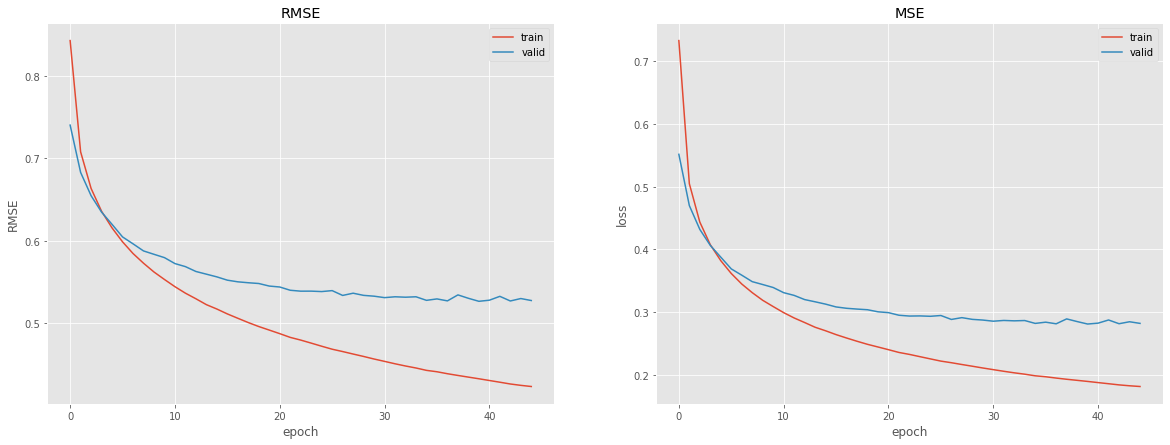

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize = (20,7))

ax1.plot(history.history['rmse'])
ax1.plot(history.history['val_rmse'])
ax1.set_title('RMSE')
ax1.set_ylabel('RMSE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('MSE')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'], loc='upper right')

plt.show()